# Curriculum Learning and LLC in Grokking

This notebook explores how curriculum learning (gradually increasing task difficulty) affects the Local Learning Coefficient (LLC) and grokking behavior in modular arithmetic.

**Based on the devinterp grokking example:**  
https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb

**Research Question:**  
Does curriculum learning (training on progressively larger primes) produce different LLC trajectories compared to direct training on the hardest task?

**Setup:**
- **Curriculum:** Train on mod-5, then mod-11, then mod-23, then mod-47, then mod-97
- **Direct:** Train directly on mod-97
- Track LLC at each stage to see how model complexity evolves

## 1. Import Required Libraries
Import torch, numpy, matplotlib, pandas, tqdm, devinterp, and other required libraries.

In [1]:
# Install required packages if running in a fresh environment
%pip install devinterp nbformat

import random
from copy import deepcopy
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/home/dorian/Projects/llc/venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Set all seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Define Experiment Parameters for Curriculum and Direct Training
Set up dataclasses or dictionaries for experiment parameters, including primes for curriculum, training hyperparameters, and random seeds.

In [3]:
@dataclass
class ExperimentParams:
    n_batches: int = 50000
    n_save_model_checkpoints: int = 100
    print_times: int = 50
    lr: float = 0.005
    batch_size: int = 128
    hidden_size: int = 48
    embed_dim: int = 12
    train_frac: float = 0.4
    random_seed: int = 0
    device: str = DEVICE
    weight_decay: float = 0.0002

# Curriculum and direct primes
CURRICULUM_PRIMES = [7, 21, 33, 49, 53]
DIRECT_PRIME = CURRICULUM_PRIMES[-1]

## 3. Define MLP Model and Utility Functions
Implement the MLP model class, test, train, and dataset utility functions as in the original grokking notebook.

In [4]:
class MLP(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.embedding = nn.Embedding(params.p, params.embed_dim)
        self.linear1r = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear1l = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear2 = nn.Linear(params.hidden_size, params.p, bias=False)
        self.act = nn.GELU()
        self.vocab_size = params.p

    def forward(self, x):
        x = x.to(self.embedding.weight.device)  # Ensure input is on same device as embedding
        x1 = self.embedding(x[..., 0])
        x2 = self.embedding(x[..., 1])
        x1 = self.linear1l(x1)
        x2 = self.linear1r(x2)
        x = x1 + x2
        x = self.act(x)
        x = self.linear2(x)
        return x

def test(model, dataset, device):
    n_correct = 0
    total_loss = 0
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            pred = torch.argmax(out)
            if pred == y:
                n_correct += 1
    return n_correct / len(dataset), total_loss / len(dataset)

def train(train_dataset, test_dataset, params, model=None, verbose=True):
    all_models = []
    if model is None:
        model = MLP(params).to(params.device)
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=params.weight_decay, lr=params.lr
    )
    loss_fn = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
    print_every = params.n_batches // params.print_times
    checkpoint_every = None
    if params.n_save_model_checkpoints > 0:
        checkpoint_every = params.n_batches // params.n_save_model_checkpoints
    loss_data = []
    if verbose:
        pbar = tqdm(total=params.n_batches, desc="Training")
    for i in range(params.n_batches):
        batch = next(iter(train_loader))
        X, Y = batch
        X, Y = X.to(params.device), Y.to(params.device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()
        if checkpoint_every and (i + 1) % checkpoint_every == 0:
            all_models += [deepcopy(model)]
        if (i + 1) % print_every == 0:
            val_acc, val_loss = test(model, test_dataset, params.device)
            train_acc, train_loss = test(model, train_dataset, params.device)
            loss_data.append(
                {
                    "batch": i + 1,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                }
            )
            if verbose:
                pbar.set_postfix(
                    {
                        "train_loss": f"{train_loss:.4f}",
                        "train_acc": f"{train_acc:.4f}",
                        "val_loss": f"{val_loss:.4f}",
                        "val_acc": f"{val_acc:.4f}",
                    }
                )
                pbar.update(print_every)
    if verbose:
        pbar.close()
    df = pd.DataFrame(loss_data)
    train_acc, train_loss = test(model, train_dataset, params.device)
    val_acc, val_loss = test(model, test_dataset, params.device)
    if verbose:
        print(f"Final Train Acc: {train_acc:.4f} | Final Train Loss: {train_loss:.4f}")
        print(f"Final Val Acc: {val_acc:.4f} | Final Val Loss: {val_loss:.4f}")
    return all_models, df

def deterministic_shuffle(lst, seed):
    random.seed(seed)
    random.shuffle(lst)
    return lst

def get_all_pairs(p):
    pairs = []
    for i in range(p):
        for j in range(p):
            pairs.append((i, j))
    return set(pairs)

def make_dataset(p):
    data = []
    pairs = get_all_pairs(p)
    for a, b in pairs:
        data.append((torch.tensor([a, b]), torch.tensor((a + b) % p)))
    return data

def train_test_split(dataset, train_split_proportion, seed):
    l = len(dataset)
    train_len = int(train_split_proportion * l)
    idx = list(range(l))
    idx = deterministic_shuffle(idx, seed)
    train_idx = idx[:train_len]
    test_idx = idx[train_len:]
    return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

## 4. Create Modular Addition Datasets for Each Prime
Generate datasets for each modulus in the curriculum (5, 11, 23, 47, 97) and for direct training (97).

In [5]:
# Prepare datasets for each prime in curriculum and for direct training
curriculum_datasets = {}
curriculum_splits = {}
for p in CURRICULUM_PRIMES:
    dataset = make_dataset(p)
    train_data, test_data = train_test_split(dataset, 0.4, 0)  # Use same split for all
    curriculum_datasets[p] = dataset
    curriculum_splits[p] = (train_data, test_data)

direct_dataset = make_dataset(DIRECT_PRIME)
direct_train_data, direct_test_data = train_test_split(direct_dataset, 0.4, 0)

## 5. Curriculum Learning Training Loop
Iteratively train the model on each modulus in the curriculum, transferring weights to the next stage, and save checkpoints after each stage.

In [6]:
curriculum_checkpoints = []
curriculum_dfs = []
prev_model = None
for i, p in enumerate(CURRICULUM_PRIMES):
    print(f"\nTraining on mod-{p} (stage {i+1}/{len(CURRICULUM_PRIMES)})")
    params = ExperimentParams()
    params.p = p
    params.device = DEVICE  # Ensure device is set
    train_data, test_data = curriculum_splits[p]
    # If not first stage, transfer weights (resize if needed)
    if prev_model is not None:
        model = MLP(params)
        # Transfer weights for layers that match
        model_dict = model.state_dict()
        prev_dict = prev_model.state_dict()
        for k in model_dict:
            if k in prev_dict and model_dict[k].shape == prev_dict[k].shape:
                model_dict[k] = prev_dict[k]
        model.load_state_dict(model_dict)
        model = model.to(params.device)  # Ensure model is on correct device
    else:
        model = None
    # Move all data to correct device
    train_data = [(x.to(params.device), y.to(params.device)) for x, y in train_data]
    test_data = [(x.to(params.device), y.to(params.device)) for x, y in test_data]
    checkpoints, df = train(train_data, test_data, params, model=model, verbose=True)
    curriculum_checkpoints.append(checkpoints)
    curriculum_dfs.append(df)
    prev_model = checkpoints[-1]


Training on mod-7 (stage 1/5)


Training: 100%|██████████| 50000/50000 [00:31<00:00, 1570.00it/s, train_loss=0.0009, train_acc=1.0000, val_loss=9.1848, val_acc=0.0000]


Final Train Acc: 1.0000 | Final Train Loss: 0.0009
Final Val Acc: 0.0000 | Final Val Loss: 9.1848

Training on mod-21 (stage 2/5)


Training: 100%|██████████| 50000/50000 [00:33<00:00, 1472.32it/s, train_loss=0.0045, train_acc=1.0000, val_loss=1.6187, val_acc=0.5509]


Final Train Acc: 1.0000 | Final Train Loss: 0.0045
Final Val Acc: 0.5509 | Final Val Loss: 1.6187

Training on mod-33 (stage 3/5)


Training: 100%|██████████| 50000/50000 [00:37<00:00, 1349.85it/s, train_loss=0.0078, train_acc=1.0000, val_loss=0.2059, val_acc=0.9557]


Final Train Acc: 1.0000 | Final Train Loss: 0.0078
Final Val Acc: 0.9557 | Final Val Loss: 0.2059

Training on mod-49 (stage 4/5)


Training: 100%|██████████| 50000/50000 [00:42<00:00, 1176.35it/s, train_loss=0.0112, train_acc=1.0000, val_loss=0.0458, val_acc=1.0000] 


Final Train Acc: 1.0000 | Final Train Loss: 0.0112
Final Val Acc: 1.0000 | Final Val Loss: 0.0458

Training on mod-53 (stage 5/5)


Training: 100%|██████████| 50000/50000 [00:45<00:00, 1110.65it/s, train_loss=0.0121, train_acc=1.0000, val_loss=0.0448, val_acc=1.0000]


Final Train Acc: 1.0000 | Final Train Loss: 0.0121
Final Val Acc: 1.0000 | Final Val Loss: 0.0448


## 6. Direct Training Loop
Train a separate model directly on mod-97, saving checkpoints as in the curriculum approach.

In [7]:
print("\nDirect training")
direct_params = ExperimentParams()
direct_params.p = DIRECT_PRIME
direct_checkpoints, direct_df = train(direct_train_data, direct_test_data, direct_params, model=None, verbose=True)


Direct training


Training: 100%|██████████| 50000/50000 [00:50<00:00, 990.24it/s, train_loss=0.0134, train_acc=1.0000, val_loss=0.0872, val_acc=0.9935]  


Final Train Acc: 1.0000 | Final Train Loss: 0.0134
Final Val Acc: 0.9935 | Final Val Loss: 0.0872


## 7. Estimate LLC at Each Curriculum Stage
For each curriculum stage checkpoint, estimate the LLC using devinterp's SGLD-based estimator.

In [8]:
def estimate_llc_given_model(model, loader, epsilon=0.03, beta=2.0, localization=5.0, num_chains=1, num_draws=500, device=DEVICE):
    return estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=epsilon, nbeta=beta, localization=localization),
        num_chains=num_chains,
        num_draws=num_draws,
        device=device,
        online=True,
    )

curriculum_llcs = []
for i, (checkpoints, p) in enumerate(zip(curriculum_checkpoints, CURRICULUM_PRIMES)):
    print(f"\nEstimating LLC for curriculum stage mod-{p}")
    params = ExperimentParams()
    params.p = p
    train_data, _ = curriculum_splits[p]
    loader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    # Use last checkpoint for each stage
    llc_stats = estimate_llc_given_model(checkpoints[-1], loader)
    print(llc_stats.keys())
    curriculum_llcs.append(llc_stats)

/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/


Estimating LLC for curriculum stage mod-7


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1076.53it/s]
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/slt/llc.py:189: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.llc_stds = self.llcs.std(dim=0)


dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

Estimating LLC for curriculum stage mod-21


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1156.55it/s]


dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

Estimating LLC for curriculum stage mod-33


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1268.24it/s]


dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

Estimating LLC for curriculum stage mod-49


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1225.07it/s]


dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

Estimating LLC for curriculum stage mod-53


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1227.93it/s]

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


In [9]:
print(curriculum_llcs[0].keys())

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


## 8. Estimate LLC for Direct Training
Estimate the LLC for each checkpoint in the direct training trajectory.

In [10]:
print("\nEstimating LLC for direct training checkpoints (mod-97)")
direct_llcs = []
loader = DataLoader(direct_train_data, batch_size=direct_params.batch_size, shuffle=True)
for i, model_checkpoint in enumerate(direct_checkpoints):
    print(f"  Checkpoint {i+1}/{len(direct_checkpoints)}")
    llc_stats = estimate_llc_given_model(model_checkpoint, loader)
    direct_llcs.append(llc_stats)


Estimating LLC for direct training checkpoints (mod-97)
  Checkpoint 1/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1068.09it/s]


  Checkpoint 2/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1089.69it/s]


  Checkpoint 3/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1078.48it/s]


  Checkpoint 4/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1191.73it/s]


  Checkpoint 5/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1228.58it/s]


  Checkpoint 6/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1251.95it/s]


  Checkpoint 7/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1202.08it/s]


  Checkpoint 8/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1189.67it/s]


  Checkpoint 9/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1210.28it/s]


  Checkpoint 10/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1204.02it/s]


  Checkpoint 11/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1188.90it/s]


  Checkpoint 12/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1180.48it/s]


  Checkpoint 13/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1270.65it/s]


  Checkpoint 14/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1214.35it/s]


  Checkpoint 15/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1267.42it/s]


  Checkpoint 16/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1253.80it/s]


  Checkpoint 17/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1238.17it/s]


  Checkpoint 18/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1194.95it/s]


  Checkpoint 19/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1163.31it/s]


  Checkpoint 20/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1090.32it/s]


  Checkpoint 21/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1096.02it/s]


  Checkpoint 22/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1045.28it/s]


  Checkpoint 23/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1069.98it/s]


  Checkpoint 24/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1084.49it/s]


  Checkpoint 25/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1051.57it/s]


  Checkpoint 26/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1113.72it/s]


  Checkpoint 27/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1094.40it/s]


  Checkpoint 28/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1074.80it/s]


  Checkpoint 29/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1083.55it/s]


  Checkpoint 30/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1104.13it/s]


  Checkpoint 31/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1109.70it/s]


  Checkpoint 32/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1080.02it/s]


  Checkpoint 33/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1060.12it/s]


  Checkpoint 34/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1140.28it/s]


  Checkpoint 35/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1188.53it/s]


  Checkpoint 36/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1232.05it/s]


  Checkpoint 37/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1229.70it/s]


  Checkpoint 38/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1214.70it/s]


  Checkpoint 39/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1098.59it/s]


  Checkpoint 40/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1085.17it/s]


  Checkpoint 41/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1096.19it/s]


  Checkpoint 42/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1106.41it/s]


  Checkpoint 43/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1067.52it/s]


  Checkpoint 44/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1100.43it/s]


  Checkpoint 45/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1101.81it/s]


  Checkpoint 46/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1114.48it/s]


  Checkpoint 47/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1219.96it/s]


  Checkpoint 48/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1198.87it/s]


  Checkpoint 49/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1208.03it/s]


  Checkpoint 50/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1268.03it/s]


  Checkpoint 51/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1261.35it/s]


  Checkpoint 52/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1244.35it/s]


  Checkpoint 53/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1239.92it/s]


  Checkpoint 54/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1203.08it/s]


  Checkpoint 55/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1220.02it/s]


  Checkpoint 56/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1160.58it/s]


  Checkpoint 57/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1175.88it/s]


  Checkpoint 58/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1198.41it/s]


  Checkpoint 59/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1215.08it/s]


  Checkpoint 60/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1256.97it/s]


  Checkpoint 61/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1215.91it/s]


  Checkpoint 62/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1072.74it/s]


  Checkpoint 63/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1109.98it/s]


  Checkpoint 64/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1105.56it/s]


  Checkpoint 65/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1086.39it/s]


  Checkpoint 66/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1094.16it/s]


  Checkpoint 67/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1095.42it/s]


  Checkpoint 68/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1075.24it/s]


  Checkpoint 69/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1174.54it/s]


  Checkpoint 70/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1208.58it/s]


  Checkpoint 71/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1248.94it/s]


  Checkpoint 72/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1227.33it/s]


  Checkpoint 73/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1252.22it/s]


  Checkpoint 74/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1275.98it/s]


  Checkpoint 75/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1190.82it/s]


  Checkpoint 76/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1229.48it/s]


  Checkpoint 77/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1233.78it/s]


  Checkpoint 78/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1203.93it/s]


  Checkpoint 79/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1119.31it/s]


  Checkpoint 80/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1093.73it/s]


  Checkpoint 81/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1106.99it/s]


  Checkpoint 82/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1118.45it/s]


  Checkpoint 83/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1093.93it/s]


  Checkpoint 84/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1097.01it/s]


  Checkpoint 85/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1092.80it/s]


  Checkpoint 86/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1239.21it/s]


  Checkpoint 87/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1215.29it/s]


  Checkpoint 88/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1237.31it/s]


  Checkpoint 89/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1194.87it/s]


  Checkpoint 90/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1225.35it/s]


  Checkpoint 91/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1237.68it/s]


  Checkpoint 92/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1230.78it/s]


  Checkpoint 93/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1253.37it/s]


  Checkpoint 94/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1196.61it/s]


  Checkpoint 95/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1225.58it/s]


  Checkpoint 96/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1201.78it/s]


  Checkpoint 97/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1235.70it/s]


  Checkpoint 98/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1198.14it/s]


  Checkpoint 99/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1179.80it/s]


  Checkpoint 100/100


Chain 0: 100%|██████████| 500/500 [00:00<00:00, 1179.82it/s]


In [11]:
print(direct_llcs[0].keys())

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


## 9. Plot Accuracy and Loss for Curriculum and Direct Training
Plot train/test accuracy and loss curves for both curriculum and direct training approaches.

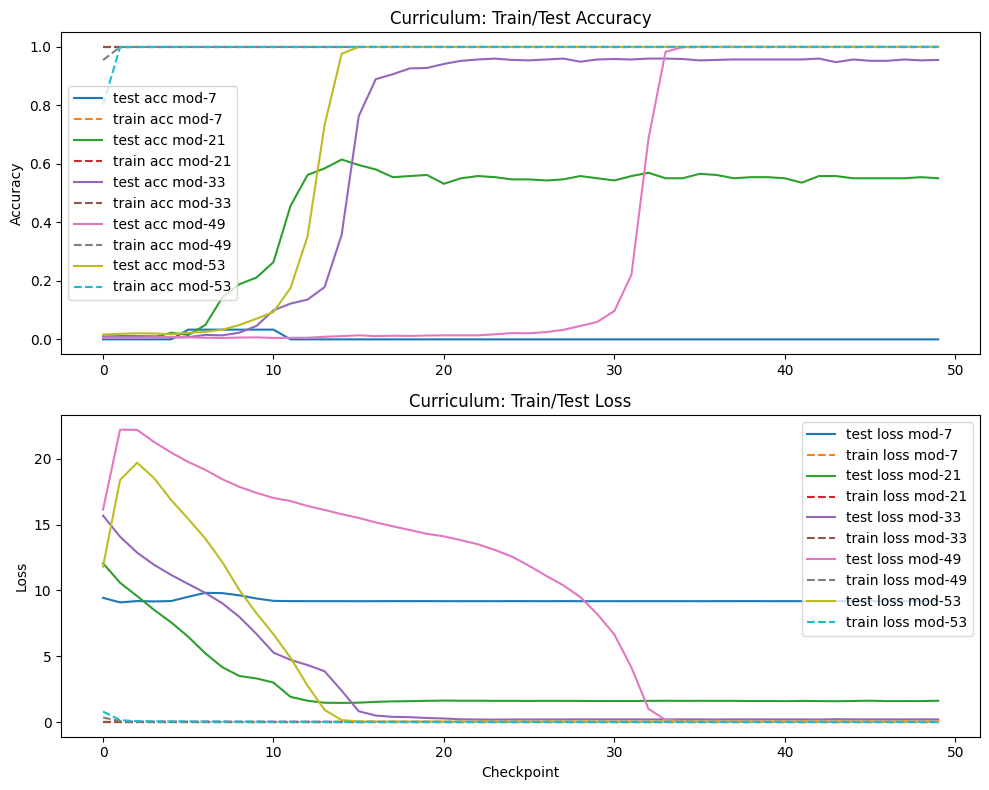

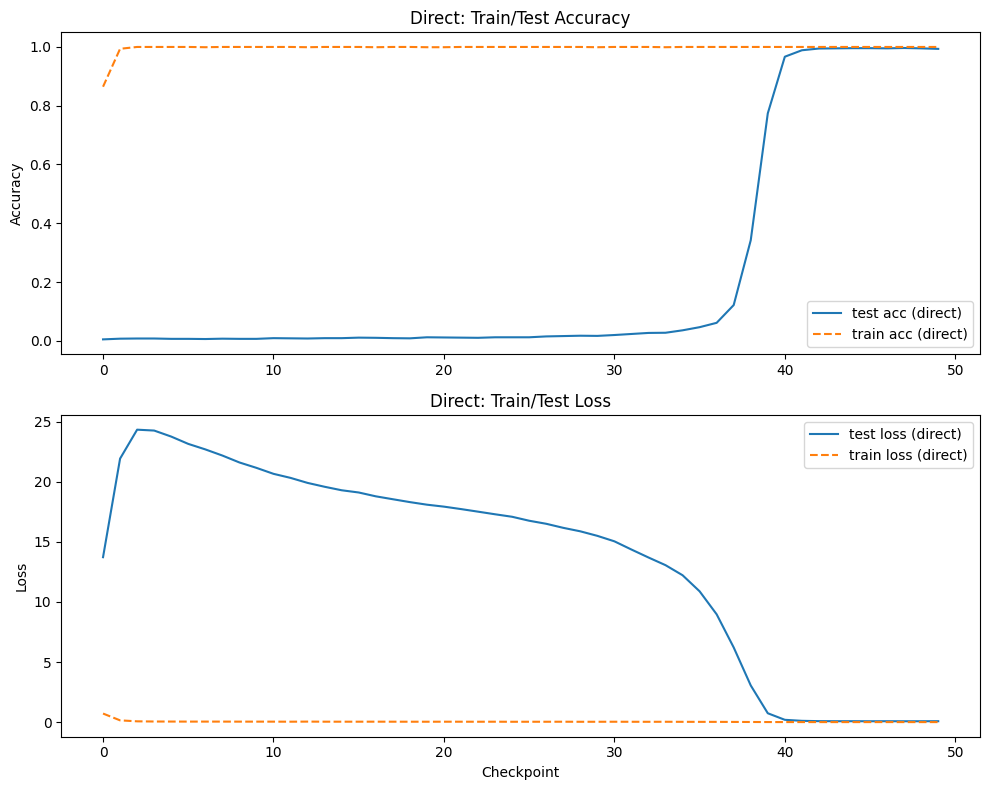

In [12]:
# Plot curriculum accuracy/loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, (df, p) in enumerate(zip(curriculum_dfs, CURRICULUM_PRIMES)):
    axs[0].plot(df["val_acc"], label=f"test acc mod-{p}")
    axs[0].plot(df["train_acc"], label=f"train acc mod-{p}", linestyle='--')
    axs[1].plot(df["val_loss"], label=f"test loss mod-{p}")
    axs[1].plot(df["train_loss"], label=f"train loss mod-{p}", linestyle='--')
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Checkpoint")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Curriculum: Train/Test Accuracy")
axs[1].set_title("Curriculum: Train/Test Loss")
plt.tight_layout()
plt.show()

# Plot direct accuracy/loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(direct_df["val_acc"], label="test acc (direct)")
axs[0].plot(direct_df["train_acc"], label="train acc (direct)", linestyle='--')
axs[1].plot(direct_df["val_loss"], label="test loss (direct)")
axs[1].plot(direct_df["train_loss"], label="train loss (direct)", linestyle='--')
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Checkpoint")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Direct: Train/Test Accuracy")
axs[1].set_title("Direct: Train/Test Loss")
plt.tight_layout()
plt.show()

**BELOW THIS LINE IS STILL WIP**

## 10. Plot LLC Trajectories for Both Approaches
Plot LLC estimates across curriculum stages and direct training checkpoints for comparison.

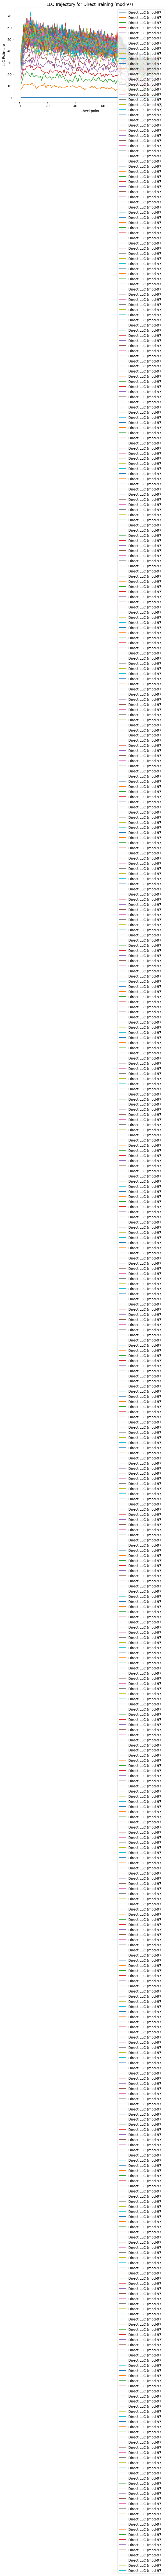

In [13]:
# # Plot LLC for curriculum (one per stage)
# curr_llc_means = [llc["llc/means"] for llc in curriculum_llcs]
# plt.figure(figsize=(8, 5))
# plt.plot(CURRICULUM_PRIMES, curr_llc_means, marker='o', label="Curriculum LLC (last checkpoint)")
# plt.xlabel("Modulus (prime)")
# plt.ylabel("LLC Estimate")
# plt.title("LLC Trajectory Across Curriculum Stages")
# plt.legend()
# plt.show()

# Plot LLC for direct training (all checkpoints)
direct_llc_means = [llc["llc/means"] for llc in direct_llcs]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(direct_llc_means)+1), direct_llc_means, label="Direct LLC (mod-97)")
plt.xlabel("Checkpoint")
plt.ylabel("LLC Estimate")
plt.title("LLC Trajectory for Direct Training (mod-97)")
plt.legend()
plt.show()

# # Overlay for comparison
# plt.figure(figsize=(10, 6))
# plt.plot([f"mod-{p}" for p in CURRICULUM_PRIMES], curr_llc_means, marker='o', label="Curriculum LLC (last of each stage)")
# plt.plot([f"direct-{i+1}" for i in range(len(direct_llc_means))], direct_llc_means, label="Direct LLC (mod-97)", alpha=0.5)
# plt.ylabel("LLC Estimate")
# plt.title("LLC Trajectories: Curriculum vs Direct Training")
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()